# Requirements

In [1]:
import re
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import scipy.stats as stats
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString

from matplotlib.patches import Patch
import seaborn as sns
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

from functools import partial
from shapely.ops import transform
import pyproj

In [2]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [3]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

In [4]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import dataset

In [5]:
# find local version of the input dataset
local_paths = !find ~/Projects -name "LIREg.parquet"
print(local_paths)

['/Users/kasev/Projects/LIRE_ETL/data/large_data/LIREg.parquet']


In [6]:
# read LIRE dataset from zenodo or locally, if already available
try:
    LIRE = gpd.read_parquet(local_paths[0])
    print("local copy found and loaded")
except:# !!! use carefully - takes time
    q = input("local file not found, try another put, or input 'y' for download")
    if q == "y":
        LIRE = gpd.read_file("https://zenodo.org/record/5074774/files/LIREg.geojson?download=1", driver="geoJSON")
        print("file downloaded from zenodo")
        LIRE.to_parquet("../data/large_data/LIREg.parquet")

local copy found and loaded


In [7]:
print(LIRE.columns.tolist())

['EDCS-ID', 'publication', 'province', 'province_list', 'place', 'place_list', 'end_yr_list', 'notes_dating', 'status_list', 'inscr_type', 'status_notation', 'inscr_process', 'notes_references', 'notes_comments', 'inscription', 'inscription_stripped_final', 'Links', 'dating from', 'dating to', 'status', 'Latitude', 'Longitude', 'photo', 'Material', 'Comment', 'EDH-ID', 'language_EDCS', 'clean_text_interpretive_word_EDCS', 'responsible_individual', 'type_of_inscription', 'letter_size', 'literature', 'work_status', 'height', 'diplomatic_text', 'people', 'depth', 'material', 'type_of_monument', 'province_label', 'width', 'transcription', 'country', 'uri', 'findspot_ancient', 'last_update', 'modern_region', 'findspot_modern', 'edh_geography_uri', 'commentary', 'trismegistos_uri', 'external_image_uris', 'fotos', 'idno_tm', 'placenames_refs', 'text_edition', 'origdate_text', 'layout_execution', 'layout_execution_text', 'support_objecttype', 'support_objecttype_text', 'support_material', 'sup


# Roman cities & Western provinces

In [18]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

In [9]:
roman_cities["pop_est"].sum()

10159670.0

In [10]:
(roman_cities["pop_est"] >= 30000).sum()

68

In [11]:
roman_cities["western_province"].sum()

889

In [12]:
roman_cities[roman_cities["western_province"]]["pop_est"].sum()

5327544.0

 # LIRE - western

In [20]:
regions_west_union = pleiades_regions_west.unary_union

In [23]:
LIRE["is_western"] = LIRE.within(regions_west_union)

In [13]:
# alternatively, we can calculate it using nearest city of each isncription
def is_nearest_western(inscriptions):
    cities = roman_cities[['western_province', 'geometry']]
    insr_geometries = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    cities_geometries = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(cities_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    is_western_df = cities.iloc[idx] # ["western_province"]
    return is_western_df["western_province"].tolist()
# LIRE["is_western"] =  is_nearest_western(LIRE)

In [24]:
LIRE["is_western"].sum()

126685

In [25]:
LIRE["is_western"].mean()

0.9226539455955719

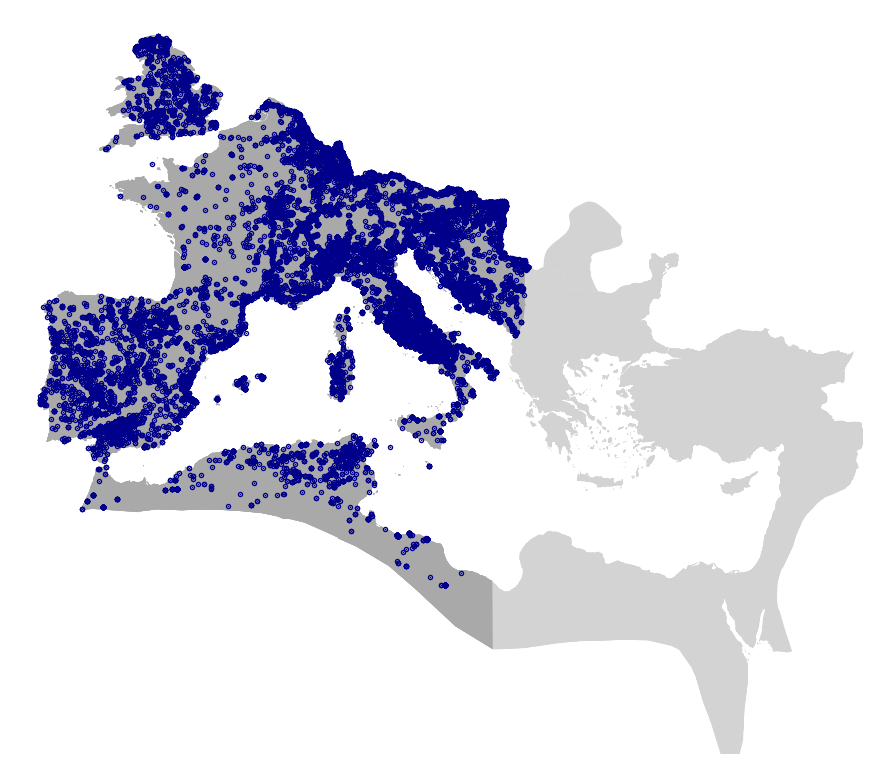

In [26]:
fig, ax = plt.subplots(figsize=[5.2, 3.2])
pleiades_regions.plot(ax=ax, color="lightgray")
pleiades_regions_west.plot(ax=ax, color="darkgray")
#roman_cities[roman_cities["western_province"]].plot(ax=ax, color="green", markersize=0.5)
LIRE[LIRE["is_western"]].plot(ax=ax, color="darkblue", markersize=0.1)
ax.set_axis_off()
ax.set_xlim(-10, 41)
ax.set_ylim(23, 55.5)
plt.show()

In [ ]:
save_figure(fig, "LIRE_western_spatial")

A file with the same name ("LIRE_western_spatial.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/LIRE_western_spatial.eps"
A file with the same name ("LIRE_western_spatial.png") already exists in this location.


 # Large, medium and small cities

In [ ]:
masks_dict = {}
masks_dict["large"] = roman_cities["pop_est"] >= 30000
masks_dict["medium"] = (roman_cities["pop_est"] >= 5000) & (roman_cities["pop_est"] < 30000)
masks_dict["small"] = small_cities_mask = roman_cities["pop_est"] < 5000

In [ ]:
for mask in masks_dict.keys():
    print(mask, len(roman_cities[masks_dict[mask]]), roman_cities[masks_dict[mask]]["pop_est"].sum())

In [ ]:
roman_cities["ID"]

In [ ]:
geod = Geod(ellps="WGS84")
def get_dist_m(inscr_geo, city_geo):
    line_string = LineString([inscr_geo, city_geo])
    return np.round(geod.geometry_length(line_string), 2)

def ckdnearest(inscriptions, cities, city_type):
    cities = cities[masks_dict[city_type]]
    cities = cities[['Ancient Toponym', 'geometry']]
    cities.rename(columns={"Ancient Toponym" : city_type + "_city_name"}, inplace=True)
    insr_geometries = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    cities_geometries = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(cities_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    nearest_cities_df = cities.iloc[idx].rename(columns={"geometry": city_type +"_city_geo"}).reset_index(drop=True)
    nearest_cities_df[city_type + "_city_geo"] = [[geom.x, geom.y] for geom in nearest_cities_df[city_type + "_city_geo"]]

    merge_gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            nearest_cities_df,
            pd.Series(dist, name=city_type + "_city_dist")
        ],
        axis=1)
    merge_gdf[city_type + "_city_dist"] = merge_gdf.apply(lambda row: get_dist_m(row.geometry, row[city_type + "_city_geo"]), axis=1)
    return merge_gdf

In [ ]:
%%time
LIRE = ckdnearest(LIRE, roman_cities, "large")
LIRE = ckdnearest(LIRE, roman_cities, "medium")
LIRE = ckdnearest(LIRE, roman_cities, "small")

In [ ]:
LIRE.head(5)

In [ ]:
fig, [ax1, ax2, ax3]=plt.subplots(3, 1, tight_layout=True)

for ax, label, color in zip([ax1, ax2, ax3], ["large", "medium", "small"], ["blue", "green", "red"]):
    sns.kdeplot(label + "_city_dist", color=color, data=LIRE, ax=ax)
    ax.set_title(label)
    ax.set_xlim(0, 1000000)
    ax.set_xticks([0, 250000, 500000, 750000, 1000000])
    ax.set_xticklabels(["0", "250km", "500km", "750km", "1000km"])
    ax.set_yticklabels([])
    if label in ["large", "medium"]:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("distance to nearest city of given type")

In [ ]:
save_figure(fig, "dist_to_nearest_by_type")

In [ ]:
LIRE[["large_city_dist", "medium_city_dist", "small_city_dist"]]

In [ ]:
LIRE[LIRE["small_city_dist"].apply(type) == list]

In [ ]:
for col in ["large_city_dist", "medium_city_dist", "small_city_dist"]:
    print([el for el in LIRE[col].tolist() if isinstance(el, list)])
    print(col)

In [ ]:
LIRE[["large_city_dist", "medium_city_dist", "small_city_dist"]] < 5000

In [ ]:
LIRE.head(5)

In [ ]:
def get_urban_context(row):
    buffer_large=5000
    buffer_medium=5000
    urban_context = "rural"
    if row["large_city_dist"] < buffer_large:
        urban_context = "large"
    else:
        if row["medium_city_dist"] < buffer_medium:
            urban_context = "medium"
        else:
            if row["small_city_dist"] < buffer_medium:
                urban_context = "small"
    return urban_context

urban_contexts_alt = LIRE.apply(lambda row: get_urban_context(row), axis=1)

In [ ]:
pd.DataFrame(pd.DataFrame(urban_contexts_alt).groupby(0).size())

In [ ]:
LIRE.to_parquet("../data/large_data/LIRE_contexts.parquet")